In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nplinker_constants import nplinker_setup
nplinker_setup(LDA_PATH='/home/simon/git/lda/code')

In [3]:
from metabolomics import load_spectra
mgf_file = '/srv/data/crusemann/gnps/METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf'
spectra = load_spectra(mgf_file)

Loaded 5930 molecules


In [5]:
from metabolomics import load_metadata
load_metadata(spectra,nodes_file)

In [6]:
from metabolomics import load_edges
edge_file = '/srv/data/crusemann/gnps/9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'
load_edges(spectra,edge_file)
from metabolomics import make_families
families = make_families(spectra)

In [7]:
import os,glob
from genomics import loadBGC_from_cluster_files
input_files = []
ann_files = []
# this is really messy - change folders to change which folers are included
# we make two lists of files - the clustering ones and the annotation ones
# clusterin gives us the mol families, networking the metadata (bigscape class etc)
# it's also really slow, because of the antismash file matching....which is a mess
# it works for this data but is incredibly non robust
root_path = '/srv/data/crusemann/bigscape/bigscape_corason_crusemann_complete_annotated_mibigs_mix_automode_20180713/network_files/2018-07-13_16-34-11_hybrids_auto_crusemann_bgcs_automode_mix_mibig'
folders = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']
# ditched 'mix' and 'others'
for folder in folders:
    fam_file = os.path.join(root_path,folder)
    cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*")
    annotation_files = glob.glob(fam_file + os.sep + "Network_*")
    input_files.append(cluster_file[0])
    ann_files.append(annotation_files[0])
    
gcf_list,bgc_list, strain_list = loadBGC_from_cluster_files(input_files,ann_files,antismash_dir='/srv/data/crusemann/antismash/justin-20181022/',antismash_format = 'flat')

Next cell adds a random object to each spectrum and gcf object, for doing the permutation testing

In [9]:
# initiate the random ones
for g in gcf_list:
    g.add_random(strain_list)
for s in spectra:
    s.add_random(strain_list)

In [ ]:
from scoring import compute_all_scores,metcalf_scoring
m_scores = compute_all_scores(spectra,gcf_list,strain_list,metcalf_scoring,do_random = True)

Done 0 of 5930
Best:  110
Best random:  110
Best:  128
Best random:  125
Best:  131
Best random:  126
Best:  134
Best random:  128
Best random:  131
Best:  138
Best:  144
Best random:  143
Best:  146
Best random:  146
Best:  148
Best random:  152
Best:  153
Best random:  153
Best random:  158
Best random:  161
Best random:  169
Best:  158
Best:  159
Best:  161
Best:  162
Best:  165
Done 100 of 5930
Best:  166
Done 200 of 5930


113
0.0144646118721


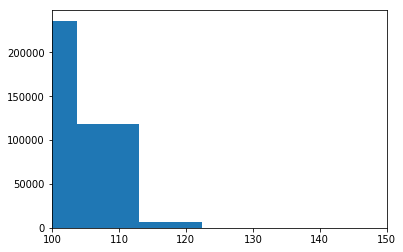

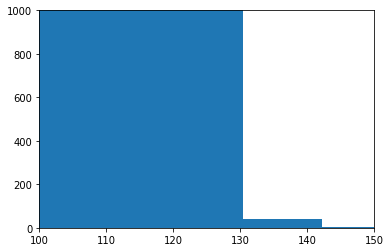

In [72]:
import pylab as plt
import numpy as np
%matplotlib inline
scores =[]
random_scores = []
for s,g in m_scores.items():
    for gg,sc in g.items():
        random_scores.append(sc[1])
        scores.append(sc[0])
plt.hist(random_scores,bins=50)
plt.xlim([100,150])
plt.figure()
plt.hist(scores,bins=50)
plt.xlim([100,150])
plt.ylim([0,1000])
random_scores.sort()
perc99 = random_scores[int(np.floor(0.99*len(random_scores)))]
print perc99
scores = np.array(scores)
n_above = len(np.where(scores>=perc99)[0])
print (1.0*n_above)/len(scores)

In [ ]:
best_spec = None
best_gcf = None
for spectrum in m_scores:
    for gcf in m_scores[spectrum]:
        if m_scores[spectrum][gcf] == best:
            best_spec = spectrum
            best_gcf = gcf

In [ ]:
print best_spec
print best_gcf
for strain in strain_list:
    print strain,best_spec.has_strain(strain),best_gcf.has_strain(strain)

In [ ]:
print best_spec.metadata['LibraryID']
for bgc in best_gcf.bgc_list:
    print bgc,bgc.bigscape_class,bgc.product_prediction

In [78]:
link_file = 'mibig_gnps_links_q3_loose.csv'
links = []
import csv
with open(link_file,'r') as f:
    reader = csv.reader(f)
    heads = reader.next()
    print heads
    for line in reader:
        links.append(line)

['#mibig_id', 'gnps_id', 'mibig_name', 'gnps_name']


In [98]:
link_dict = {}
for link in links:
    short_gnps_name = link[3].split()[0]
    link_dict[short_gnps_name] = link[0]    

In [102]:
spec_lib_dict = {}
for spectrum in spectra:
    if spectrum.metadata['LibraryID']:
        lid = spectrum.metadata['LibraryID'].split()[0]
        if lid in link_dict:
            spec_lib_dict[spectrum] = lid

In [107]:
for spec in spec_lib_dict:
    bgc_name = link_dict[spec_lib_dict[spec]]
    print bgc_name
    bgc = [b for b in bgc_list if b.name.startswith(bgc_name)]
    print bgc

BGC0000198
[]
BGC0001830
[]
BGC0000136
[]
BGC0001766
[]
BGC0001766
[]
BGC0001572
[]
BGC0000241
[]
BGC0000136
[]
BGC0001572
[]
BGC0000426
[]
BGC0000826
[]
BGC0000198
[]
BGC0000333
[]
BGC0001830
[]
BGC0001766
[]
BGC0000241
[]
BGC0000220
[]
BGC0000241
[]
BGC0000198
[]
BGC0000826
[]
BGC0001572
[]
BGC0001572
[]
BGC0000136
[]


In [106]:
print [b.name for b in bgc_list if b.name.startswith('BGC')]

['BGC0000181.1', 'BGC0001383.1', 'BGC0001031.1', 'BGC0001032.1', 'BGC0000995.1', 'BGC0001113.1', 'BGC0000418.1', 'BGC0000419.1', 'BGC0000995.1', 'BGC0001113.1', 'BGC0000064.1', 'BGC0001268.1', 'BGC0001096.1', 'BGC0000976.1', 'BGC0001165.1', 'BGC0000989.1', 'BGC0000990.1', 'BGC0001041.1', 'BGC0000991.1', 'BGC0001009.1', 'BGC0001010.1', 'BGC0000689.1', 'BGC0000697.1', 'BGC0001241.1', 'BGC0001267.1', 'BGC0001322.1', 'BGC0001324.1', 'BGC0000611.1', 'BGC0000655.1', 'BGC0000611.1', 'BGC0000655.1', 'BGC0000564.1', 'BGC0001170.1', 'BGC0000491.1', 'BGC0001222.1', 'BGC0000530.1', 'BGC0000533.1', 'BGC0000064.1', 'BGC0001268.1', 'BGC0000989.1', 'BGC0000991.1', 'BGC0000157.1', 'BGC0000158.1', 'BGC0001009.1', 'BGC0001010.1', 'BGC0001041.1', 'BGC0000976.1', 'BGC0001165.1', 'BGC0000958.1', 'BGC0001216.1', 'BGC0001340.1', 'BGC0001385.1', 'BGC0000004.1', 'BGC0000008.1', 'BGC0001259.1', 'BGC0001272.1', 'BGC0001264.1', 'BGC0001280.1', 'BGC0000006.1', 'BGC0000076.1', 'BGC0000077.1', 'BGC0000979.1', 'BGC000